# Import Libraries, Load Data

### Imports

In [7]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

### Setting up Data

In [8]:
# # Paths:
# price_path = '/Users/tuckeringlefield/Desktop/price_data_from_shardar.csv'
# cap_path = '/Users/tuckeringlefield/Desktop/Data_Science/Math_4920/DNR_Data/FinanceData/cap_data_from_shardar.csv'
price_path = "C:/Users/Owner/school/math4920/price_data_from_shardar.csv"
cap_path = "C:/Users/Owner/school/math4920/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [29]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%***********************]  1 of 1 completed


# Functions

## Helper Functions

In [9]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(dataframe, date_start, date_end, num_stocks):
    target_date = date_end + 1
    selected_row = caps_df.iloc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [10]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [11]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [12]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [13]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict

In [14]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [15]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [16]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return math.floor(beta*100)/100

In [17]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [43]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, mean

## Main Functions

In [80]:
def monitor_pair_for_day(prices_with_market, window_size, stock_pair, pair_dictionary, current_day, currently_trading_stocks, spread_return_percentages):
    
    if pair_dictionary["current_spread_mean"] is None:
        # Need to find spread mean for past 90 days
        past_window_data = prices_with_market[current_day - window_size : current_day]
        
        # Find new hedge ratio
        pair_dictionary["current_hedge_ratio"] = float(calculate_beta_for_pair(past_window_data, stock_pair))
        
        # Upper, lower limits and mean
        pair_dictionary["spread_upper_limit"], pair_dictionary["spread_lower_limit"], pair_dictionary["current_spread_mean"] = get_spread_limits_for_past_months(past_window_data, stock_pair, float(pair_dictionary["current_hedge_ratio"]))
        
        
        curr_day_spread = prices_with_market[stock_pair[0]].iloc[current_day]-float(pair_dictionary["current_hedge_ratio"])*prices_with_market[stock_pair[1]].iloc[current_day]
        total_investment = prices_with_market[stock_pair[0]].iloc[current_day] + np.abs(float(pair_dictionary["current_hedge_ratio"]))*prices_with_market[stock_pair[1]].iloc[current_day]
        
        if curr_day_spread >= pair_dictionary["spread_upper_limit"]:
            date = prices_with_market.iloc[current_day].name.strftime('%Y-%m-%d')
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "upper"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])
        elif curr_day_spread <= pair_dictionary["spread_lower_limit"]:
            date = prices_with_market.iloc[current_day].name.strftime('%Y-%m-%d')
            pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
            pair_dictionary["trade_status_message"] = "Currently in trade"
            pair_dictionary["trade_day_spread_position"] = "lower"
            pair_dictionary["currently_trading"] = True
            have_days_to_trade = True    
            # Found a trading day, add to list
            currently_trading_stocks.append(stock_pair[0])
            currently_trading_stocks.append(stock_pair[1])  
    else:
        # Need current day spread
        curr_day_spread = prices_with_market[stock_pair[0]].iloc[current_day]-float(pair_dictionary["current_hedge_ratio"])*prices_with_market[stock_pair[1]].iloc[current_day]
        total_investment = prices_with_market[stock_pair[0]].iloc[current_day] + np.abs(float(pair_dictionary["current_hedge_ratio"]))*prices_with_market[stock_pair[1]].iloc[current_day]

        # Looking for open trading days
        if pair_dictionary["currently_trading"] == False:
            if curr_day_spread >= pair_dictionary["spread_upper_limit"]:
                date = prices_with_market.iloc[current_day].name.strftime('%Y-%m-%d')
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Selling spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "upper"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
            elif curr_day_spread <= pair_dictionary["spread_lower_limit"]:
                date = prices_with_market.iloc[current_day].name.strftime('%Y-%m-%d')
                pair_dictionary['trade_info']["open_trade_dates"].append((date, "Buying spread", curr_day_spread, total_investment, float(pair_dictionary["current_hedge_ratio"])))
                pair_dictionary["trade_status_message"] = "Currently in trade"
                pair_dictionary["trade_day_spread_position"] = "lower"
                pair_dictionary["currently_trading"] = True
                have_days_to_trade = True    
                # Found a trading day, add to list
                currently_trading_stocks.append(stock_pair[0])
                currently_trading_stocks.append(stock_pair[1])
        else:
            if (pair_dictionary["trade_day_spread_position"] == "upper" and curr_day_spread <= pair_dictionary["current_spread_mean"]) or (pair_dictionary["trade_day_spread_position"] == "lower" and curr_day_spread >= pair_dictionary["current_spread_mean"]):
                # Close the trade, mean reverted
                # Found a closing day
                date = prices_with_market.iloc[current_day].name.strftime('%Y-%m-%d')
                pair_dictionary['trade_info']["close_trade_dates"].append((date, 'Stocks mean reverted', curr_day_spread))
                # Calculate the spread difference percentage 
                open = pair_dictionary['trade_info']['open_trade_dates'][-1][2]
                close = curr_day_spread
                percent_return = 0
                if pair_dictionary['trade_day_spread_position'] == 'upper':
                    #(open-close)/open
                    percent_return = (open-curr_day_spread)/total_investment *100   
                else:
                    #(close-open)/open
                    percent_return = (curr_day_spread-open)/total_investment *100
                    # appending percentages to list and removing stock pair from currently trading
                percent_formatted = math.floor(percent_return*100)/100
                print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                spread_return_percentages.append(percent_formatted)
                pair_dictionary["trade_status_message"] = "Looking for trading days"
                pair_dictionary["trade_day_spread_position"] = "unknown"
                pair_dictionary["currently_trading"] = False
                have_days_to_trade = True
                # Removed stocks from being traded because they just closed
                currently_trading_stocks.remove(stock_pair[0])
                currently_trading_stocks.remove(stock_pair[1])
        
    return pair_dictionary, spread_return_percentages

In [74]:
def monitor_pairs(window_size, stock_group_size, stop_after_days):
    global prices_with_market
    currently_trading_stocks = []
    existing_stocks = {}
    currently_monitoring_pairs = []
    spread_return_percentages = []
    
    for day in range(stop_after_days):
        window_start_index = day
        window_end_index = day + window_size
            
        if day % 7 == 0:
            print(f'----------- Weeks Running: {day // 7} --------------------')
            # Find new pairs
            top_liquid_stocks = find_top_liquid_stocks(prices_with_market, window_start_index , window_end_index, stock_group_size)
            liquid_stocks_not_null = []
            window_stock_data = prices_with_market[window_start_index: window_end_index]
            for stock in top_liquid_stocks:
                num_nulls_for_stock = window_stock_data[stock].isnull().sum().item()
                if num_nulls_for_stock == 0:
                    liquid_stocks_not_null.append(stock)  
                    
            # Check if we need to reset hedge ratio and spread mean
            currently_monitoring_pairs_copy = currently_monitoring_pairs.copy()
            for stock_pair in currently_monitoring_pairs_copy:
                if existing_stocks[stock_pair]["currently_trading"] == False:
                    existing_stocks[stock_pair]["current_spread_mean"] = None
                    existing_stocks[stock_pair]["current_hedge_ratio"] = None
                if stock_pair[0] in liquid_stocks_not_null and stock_pair[1] in liquid_stocks_not_null:
                    # Check if pair is still cointegrated
                    if is_still_cointegrated(window_stock_data, stock_pair, 0.05):
                        continue
                    else:
                        current_day_string = prices_with_market.iloc[window_end_index].name.strftime('%Y-%m-%d')
                        if existing_stocks[stock_pair]["currently_trading"]:
                            # Calculate current day spread
                            curr_day_spread = prices_with_market[stock_pair[0]].iloc[window_end_index]-float(existing_stocks[stock_pair]["current_hedge_ratio"])*prices_with_market[stock_pair[1]].iloc[window_end_index]
                            # Close trade due to cointegration
                            existing_stocks[stock_pair]["currently_trading"] = False
                            existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'Stocks are no longer cointegrated', curr_day_spread))
                            # Calculate the spread difference percentage 
                            open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                            total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                            if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                                #(open-close)/open
                                percent_return = ((open-curr_day_spread)/total_investment) *100   
                            else:
                                #(close-open)/open
                                percent_return = ((curr_day_spread-open)/total_investment) *100
                            # appending percentages to list and removing stock pair from currently trading
                            percent_formatted = math.floor(percent_return*100)/100
                            print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                            spread_return_percentages.append(percent_formatted)
                            currently_trading_stocks.remove(stock_pair[0])
                            currently_trading_stocks.remove(stock_pair[1])
        
                        existing_stocks[stock_pair]["should_monitor"] = False
                        existing_stocks[stock_pair]["current_spread_mean"] = None
                        existing_stocks[stock_pair]["current_hedge_ratio"] = None
                        existing_stocks[stock_pair]["is_cointegrated"] = False
                        existing_stocks[stock_pair]["trade_status_message"] = 'Stocks no longer cointegrated'
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                        existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                        currently_monitoring_pairs.remove(stock_pair)
                else:
                    current_day_string = prices_with_market.iloc[window_end_index].name.strftime('%Y-%m-%d')
                    if existing_stocks[stock_pair]["currently_trading"]:
                        # Calculate current day spread
                        curr_day_spread = prices_with_market[stock_pair[0]].iloc[window_end_index]-float(existing_stocks[stock_pair]["current_hedge_ratio"])*prices_with_market[stock_pair[1]].iloc[window_end_index]
                        # Close trade due to liquidity
                        existing_stocks[stock_pair]["currently_trading"] = False
                        existing_stocks[stock_pair]['trade_info']["close_trade_dates"].append((current_day_string, 'One or more stocks is not liquid enough to trade', curr_day_spread))
                        # Calculate the spread difference percentage 
                        open = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][2]
                        total_investment = existing_stocks[stock_pair]['trade_info']['open_trade_dates'][-1][-2]
                        if existing_stocks[stock_pair]['trade_day_spread_position'] == 'upper':
                            #(open-close)/open
                            percent_return = ((open-curr_day_spread)/total_investment) *100   
                        else:
                            #(close-open)/open
                            percent_return = ((curr_day_spread-open)/total_investment) *100
                        # appending percentages to list and removing stock pair from currently trading
                        percent_formatted = math.floor(percent_return*100)/100
                        print(f"Stock pair: {stock_pair}, percentage: {percent_formatted}")
                        spread_return_percentages.append(percent_formatted)
                        currently_trading_stocks.remove(stock_pair[0])
                        currently_trading_stocks.remove(stock_pair[1])
    
                    existing_stocks[stock_pair]["should_monitor"] = False
                    existing_stocks[stock_pair]["current_spread_mean"] = None
                    existing_stocks[stock_pair]["current_hedge_ratio"] = None
                    existing_stocks[stock_pair]["is_cointegrated"] = None
                    existing_stocks[stock_pair]["trade_status_message"] = 'Stocks not liquid enough to trade'
                    existing_stocks[stock_pair]["monitoring_end_dates"].append(current_day_string)  
                    existing_stocks[stock_pair]["trade_day_spread_position"] = 'unknown'
                    currently_monitoring_pairs.remove(stock_pair)
                        
                                    
            # Clustering
            diff_df = filter_diff_df(prices_with_market, window_start_index , window_end_index, liquid_stocks_not_null)
            window_highly_liquid_stocks_price_df = filter_df_by_dates(prices_with_market, window_start_index , window_end_index, liquid_stocks_not_null)
            beta_df = calculate_betas(diff_df, window_start_index , window_end_index, liquid_stocks_not_null)

            merged_df = diff_df.merge(beta_df, how = 'cross')
            res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
            cluster_dict = cluster_the_matrix(res_df, 3)
            clustered_stock_pairs = find_cointegrated_pairs(window_highly_liquid_stocks_price_df, cluster_dict, 0.05)
            for stock_pair in clustered_stock_pairs:
                # Destructure to check not in existing
                stock1, stock2 = stock_pair
                if stock1 in currently_trading_stocks or stock2 in currently_trading_stocks:
                    continue
                if ((stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks):
                    # Start monitoring and add to list
                    existing_stocks[stock_pair] = {
                        "is_cointegrated" : True,
                        "should_monitor" : True,
                        "trade_status_message" : "Looking for trading days",
                        "monitoring_start_dates" : [prices_with_market.iloc[window_end_index].name.strftime('%Y-%m-%d')],
                        "monitoring_end_dates" : [],
                        
                        'trade_info' : {
                            "open_trade_dates" : [],
                            "close_trade_dates" : [],
                        },
                        
                        "trade_day_spread_position": "unknown",
                        "current_hedge_ratio": None,
                        "current_spread_mean": None,
                        "spread_upper_limit": None,
                        "spread_lower_limit": None,
                        "currently_trading": False
                    }
                    currently_monitoring_pairs.append(stock_pair)
                else:
                    if (stock1, stock2) in existing_stocks:
                        stock_pair = (stock1, stock2)
                    else:
                        stock_pair = (stock2, stock1)
                    # Check if stock pair was being monitored last week
                    if existing_stocks[stock_pair]["should_monitor"] :
                        continue
                    else:
                        # Stock pair was not being monitored last week, but we should start monitoring
                        existing_stocks[stock_pair]["monitoring_start_dates"].append(prices_with_market.index[window_end_index].strftime('%Y-%m-%d'))
                        existing_stocks[stock_pair]["should_monitor"] = True
                        existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                        existing_stocks[stock_pair]["is_cointegrated"] = True
                        currently_monitoring_pairs.append(stock_pair)
                        
        # Daily process to check the spreads
        for stock_pair in currently_monitoring_pairs:
            if existing_stocks[stock_pair]["currently_trading"] or (stock_pair[0] not in currently_trading_stocks and stock_pair[1] not in currently_trading_stocks):
                existing_stocks[stock_pair], spread_return_percentages = monitor_pair_for_day(prices_with_market, window_size, stock_pair, existing_stocks[stock_pair], window_end_index, currently_trading_stocks, spread_return_percentages)

    return existing_stocks, spread_return_percentages

## Visualizations

In [23]:
def construct_periods(start_dates, end_dates):
    periods = []

    min_length = min(len(start_dates), len(end_dates))

    # Pair each start date with the corresponding end date
    for i in range(min_length):
        periods.append((start_dates[i], end_dates[i]))

    # Handle cases where the lists are of unequal length
    if len(start_dates) > len(end_dates):
        # If there are more start dates, pair the remaining ones with None (or a placeholder)
        for j in range(min_length, len(start_dates)):
            periods.append((start_dates[j], None))
    elif len(end_dates) > len(start_dates):
        # If there are more end dates, pair the remaining ones with the last start date
        for j in range(min_length, len(end_dates)):
            periods.append((start_dates[-1], end_dates[j]))

    return periods

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pprint

def print_overall_display(pairs_dictionary, end_date):
    global prices_with_market
    # data = pairs_dictionary

    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = pairs_dictionary

    num_pairs = len(filtered_data)
    num_needed_plots = 0
    if num_pairs%20 != 0:
        num_needed_plots = num_pairs//20 + 1
    else:
        num_needed_plots = num_pairs//20
    # Sort the pairs into chunks for printing 
    indexing_var = 0
    keys = list(filtered_data.keys())
    print(keys)
    plotting_dict = {}
    for plot in range(num_needed_plots):
        plotting_dict[f'Plot_{plot+1}'] = []
        for j in range(20):
            if indexing_var == num_pairs-1:
                continue
            plotting_dict[f'Plot_{plot+1}'].append(keys[indexing_var])
            indexing_var +=1
    
    #pprint.pprint(plotting_dict)

    # Iterate over the plotting_dict to create plots
    for plot_name, pairs in plotting_dict.items():
        fig, ax = plt.subplots(figsize=(15, 10))  # Adjust the size as needed
        print(f"Creating {plot_name} with pairs: {pairs}")

        # Get the data for the current set of pairs
        chunk_data = [(key, filtered_data[key]) for key in pairs if key in filtered_data]

        # Iterate over the chunk data to plot
        for idx, (key, value) in enumerate(chunk_data):
            label = f"{key[0]}-{key[1]}"

            # Extract periods
            periods_start = [str_to_date(date) for date in value['monitoring_start_dates']]
            periods_end = [str_to_date(date) for date in value['monitoring_end_dates']]
            periods = construct_periods(periods_start, periods_end)

            # Extract event dates
            open_trade_dates = [str_to_date(date[0]) for date in value['open_trade_dates']]
            close_trade_dates = [str_to_date(date[0]) for date in value['close_trade_dates']]

            # Plot each period as a line
            for start, end in periods:
                if end is None:
                    end = prices_with_market.iloc[end_date].name.strftime('%Y-%m-%d')
                ax.plot([start, end], [idx, idx], color='black')

            # Plot open trade dates as green dots
            if open_trade_dates:
                ax.plot(open_trade_dates, [idx] * len(open_trade_dates), 'o', color='green', label='Open Trade Dates' if idx == 0 else "")

            # Plot close trade dates as red dots
            if close_trade_dates:
                ax.plot(close_trade_dates, [idx] * len(close_trade_dates), 'o', color='red', label='Close Trade Dates' if idx == 0 else "")

        # Formatting the plot
        y_labels = [f"{key[0]}-{key[1]}" for key, _ in chunk_data]
        if y_labels:
            ax.set_yticks(range(len(y_labels)))
            ax.set_yticklabels(y_labels, fontsize=10, horizontalalignment='right')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.xticks(rotation=45)
        plt.xlabel('Date')
        plt.title(f'Event Timelines for {plot_name}')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [25]:
# function to print open/close days with prices
def print_trading_with_prices(dict, end_date):
    global prices_with_market
    
    # Function to convert date strings to datetime objects
    def str_to_date(date_str):
        return datetime.strptime(date_str, '%Y-%m-%d')

    # Filter out keys with no periods or events
    filtered_data = {
        key: value for key, value in dict.items()
        if (value['monitoring_start_dates'] or value['monitoring_end_dates'] or
            value['open_trade_dates'] or value['close_trade_dates'])
    }
    
    
    for key in filtered_data:
        open_trade_dates = []
        for item in filtered_data[key]['open_trade_dates']:
            date = item[0]
            open_trade_dates.append(date)
        close_trade_dates = []
        for item in filtered_data[key]['close_trade_dates']:
            date = item[0]
            close_trade_dates.append(date)
        if len(open_trade_dates) == 0:
            continue
        #plot the pair
        if len(open_trade_dates) > 1:
            plot_start_date = open_trade_dates[0]
            plot_end_date = close_trade_dates[-1]
        else:
            # need to move the dates a month behind and head, respectively
            trade_start_loc = prices_with_market.index.get_loc(open_trade_dates[0])
            plot_start_loc = trade_start_loc - 14
            if plot_start_loc < 0:
                plot_start_loc = 0
            plot_start_date = prices_with_market.index[plot_start_loc]
            if len(close_trade_dates) == 0:
                trade_end_date = prices_with_market.index[plot_end_loc]
            else:
                trade_end_date = close_trade_dates[-1]
            trade_end_loc = prices_with_market.index.get_loc(trade_end_date)
            plot_end_loc = trade_end_loc + 14
            # need to impliment some sort of out of range check for this in the future...
            plot_end_date = prices_with_market.index[plot_end_loc]
        prices_with_market[[key[0], key[1]]][plot_start_date:plot_end_date].plot()
        plt.title(f"{key}")
        # list of strings with messages
        trades_info = []
        num_trades = max(len(open_trade_dates), len(close_trade_dates))
        for i in range(num_trades):
            string = ''
            open_date = open_trade_dates[i]
            try:
                close_date = close_trade_dates[i]
                message = filtered_data[key]['close_trade_dates'][i][1]
            except IndexError:
                close_date = ''
                message = 'Stock in trade'
            string = '(' + open_date + '-' + close_date + ') : ' + message
            trades_info.append(string)    
        # Add vertical green lines for open_trade_dates
        for date in open_trade_dates:
            plt.axvline(x=date, color='green', linestyle='--', linewidth=1)
        # Add vertical red lines for close_trade_dates
        for date in close_trade_dates:
            plt.axvline(x=date, color='red', linestyle='--', linewidth=1)
        plt.show()
        print("Trades: ")
        pprint.pprint(trades_info)

In [26]:
def print_spread_with_trading_charts(data_dict, end_date):
    global prices_with_market
    for key in data_dict:
        if not data_dict[key]['open_trade_dates'] or not data_dict[key]['monitoring_start_dates']:
            continue
        
        monitoring_start_dates = data_dict[key]['monitoring_start_dates']
        monitoring_end_dates = data_dict[key]['monitoring_end_dates']
        open_trade_dates = [day[0] for day in data_dict[key]['open_trade_dates']]
        close_trade_dates = [day[0] for day in data_dict[key]['close_trade_dates']]
        
        stock1, stock2 = key
        periods = construct_periods(open_trade_dates,close_trade_dates)
        close_trade_tuples = data_dict[key]['close_trade_dates']

        for period in periods:
            spread_start_date = period[0]
            if len(period) > 1:
                if period[1] == None:
                    spread_end_date = end_date
                else:
                    spread_end_date = period[1]
            else:
                spread_end_date = end_date
            
            position_1 = prices_with_market.index.get_loc(spread_start_date)
            start_position = max(0, position_1 - 89)
            past_three_months_all_data = prices_with_market.iloc[start_position:position_1 + 1]
            past_three_months_data = past_three_months_all_data[[stock1, stock2]]
                
            beta = calculate_beta_for_pair(past_three_months_data, key)
            upper, lower, pair_order, mean_val = get_spread_limits_for_past_months(past_three_months_data, key, beta)
                
            price_data = prices_with_market[[stock1, stock2]].loc[spread_start_date:spread_end_date]
            spread_data = price_data[pair_order[0]] - beta * price_data[pair_order[1]]
            dates = spread_data.index
            values = spread_data.values

            # # Determine color for each date
            # colors = []
            # for date in dates:            
            #     if date_str in open_trade_dates:
            #         colors.append('green')
            #     elif date_str in close_trade_dates:
            #         colors.append('red')
            #     else:
            #         colors.append('black')
            colors = 'black'

            # Plot the data
            plt.figure(figsize=(10, 6))
            plt.axhline(y=mean_val, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
            plt.axhline(y=upper, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
            plt.axhline(y=lower, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
            plt.scatter(dates, values, c=colors)
            plt.title(f"Spread data for: {key} for trade: {period}")
            plt.xlabel('Date')
            plt.ylabel('Value')
            plt.legend()
            plt.grid(True)
            plt.show()

            # find the message   
            string = ''
            open_date = spread_start_date
            close_date = spread_end_date
            message = 'Stocks currently in trade'
            for tuple in close_trade_tuples:
                if tuple[0] == close_date:
                    message = tuple[1]
            string = '(' + open_date + '-' + close_date + ') : ' + message  
            print('Trades: ') 
            print(string)

In [27]:
def print_all_visualizations(dict, end_date):
    print_overall_display(dict)
    print_trading_with_prices(dict, end_date)
    print_spread_with_trading_charts(dict, end_date)

# Running Code

In [81]:
# Run Main code
import pprint as pprint
num_days_to_run = 100
window_size_in_days = 180
num_liquid_stocks_to_consider = 30
results, spread_percentages = monitor_pairs(window_size_in_days, num_liquid_stocks_to_consider, num_days_to_run)
pprint.pprint(results)
print(spread_percentages)

----------- Weeks Running: 0 --------------------
----------- Weeks Running: 1 --------------------
Stock pair: ('SDLI', 'NRTLQ'), percentage: 4.17
Stock pair: ('GLW', 'SEBL'), percentage: -9.01
----------- Weeks Running: 2 --------------------
Stock pair: ('CMRCQ', 'BB'), percentage: -0.19
----------- Weeks Running: 3 --------------------
Stock pair: ('CIEN', 'SEBL'), percentage: -1.66
Stock pair: ('ARBA', 'ITWO'), percentage: -2.76
Stock pair: ('AMCC', 'JNPR'), percentage: 2.52
----------- Weeks Running: 4 --------------------
Stock pair: ('CSCO', 'TWX'), percentage: -2.72
----------- Weeks Running: 5 --------------------
Stock pair: ('LVLT', 'MSFT'), percentage: -7.9
Stock pair: ('NTAP', 'ITWO'), percentage: -3.3
Stock pair: ('CIEN', 'SEBL'), percentage: 7.73
----------- Weeks Running: 6 --------------------
Stock pair: ('EXTR', 'AMCC'), percentage: 0.72
----------- Weeks Running: 7 --------------------
Stock pair: ('BRCM', 'ARBA'), percentage: -8.85
Stock pair: ('PMCS', 'VRSN'), pe

In [85]:
len(results)

68

21.27
0.6077142857142857
35
16
19


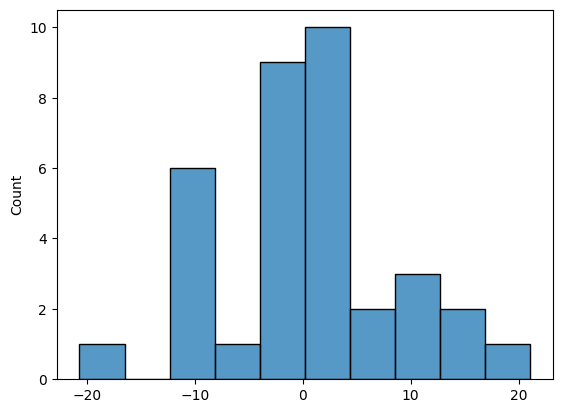

In [91]:
print(sum(spread_percentages))
print(np.mean(spread_percentages))
print(len(spread_percentages))
# sns.boxplot(spread_percentages)
sns.histplot(spread_percentages)
num_below = 0
num_above = 0
for num in spread_percentages:
    if num > 0:
        num_above += 1
    else:
        num_below += 1

print(num_below)
print(num_above)

<Axes: xlabel='date'>

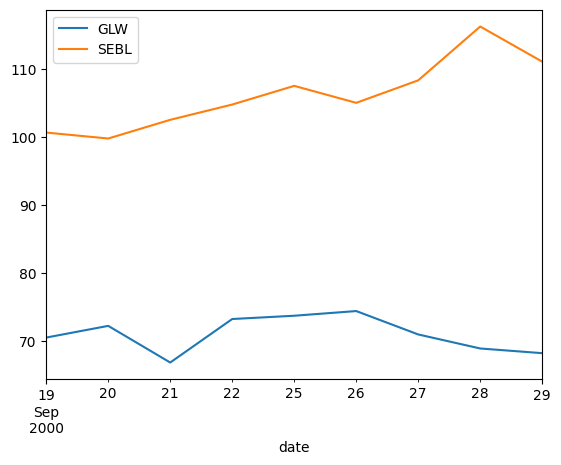

In [77]:
prices_with_market[['GLW', 'SEBL']]['2000-09-19':'2000-09-30'].plot()


In [64]:
end_row_num = prices_with_market.index.get_loc('2000-10-09')
start_row_num = end_row_num - 180
quick_price_data = prices_with_market.iloc[start_row_num:end_row_num]

calculate_beta_for_pair(quick_price_data, ('AMCC', 'JNPR'))

1.932618021009659

In [65]:
# Visualizations FIXME!!!
#print_all_visualizations(results)
#print_overall_display(results, #FIXME!!)
#print_trading_with_prices(results, #FIXME!!)
#print_spread_with_trading_charts(results, #FIXME!!!)